In [ ]:
%pip install torch
%pip install git+https://github.com/illuin-tech/colpali
%pip install pdf2image pypdf

In [1]:
import os

import torch
from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.utils.colpali_processing_utils import (
    process_images,
    process_queries,
)
from pdf2image import convert_from_path
from PIL import Image
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor


/Users/yi/Library/Caches/pypoetry/virtualenvs/colpali-Ey9hsOnx-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "mps" # Apple
type = torch.bfloat16

# Load model
model_name = "vidore/colpali"
token = os.environ.get("HF_TOKEN")
model = ColPali.from_pretrained(
    "google/paligemma-3b-mix-448", torch_dtype=type, device_map=device, token=token).eval()

model.load_adapter(model_name)
processor = AutoProcessor.from_pretrained(model_name, token=token)

/Users/yi/Library/Caches/pypoetry/virtualenvs/colpali-Ey9hsOnx-py3.12/lib/python3.12/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 3/3 [00:12<00:00,  4.22s/it]
Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight', 'language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

In [3]:
files = ["climate_youth_magazine.pdf"]

images = []
for f in files:
    images.extend(convert_from_path(f))

# run inference - docs
dataloader = DataLoader(
    images,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: process_images(processor, x),
)

print(model.device)


mps:0


In [4]:
ds = []

for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

# print(f"Uploaded and converted {len(images)} pages")


100%|██████████| 8/8 [05:54<00:00, 44.29s/it]


In [11]:
print(len(ds))

32


In [28]:
from PIL import Image
from mteb.evaluation.evaluators import RetrievalEvaluator

class CustomEvaluator:
    def __init__(self, is_multi_vector=False):
        self.is_multi_vector = is_multi_vector
        self.mteb_evaluator = RetrievalEvaluator()

    def evaluate(self, qs, ps):
        if self.is_multi_vector:
            scores = self.evaluate_colbert(qs, ps)
        else:
            scores = self.evaluate_biencoder(qs, ps)

        assert scores.shape[0] == len(qs)

        arg_score = scores.argmax(dim=1)
        # compare to arange
        accuracy = (arg_score == torch.arange(scores.shape[0], device=scores.device)).sum().item() / scores.shape[0]
        print(arg_score)
        print(f"Top 1 Accuracy (verif): {accuracy}")

        # cast to numpy
        # scores = scores.cpu().numpy()
        scores = scores.to(torch.float32).cpu().numpy()
        return scores

    def compute_metrics(self, relevant_docs, results, **kwargs):
        # wrap mteb package

        ndcg, _map, recall, precision, naucs = self.mteb_evaluator.evaluate(
            relevant_docs,
            results,
            self.mteb_evaluator.k_values,
            ignore_identical_ids=kwargs.get("ignore_identical_ids", True),
        )
        mrr = self.mteb_evaluator.evaluate_custom(relevant_docs, results, self.mteb_evaluator.k_values, "mrr")
        scores = {
            **{f"ndcg_at_{k.split('@')[1]}": v for (k, v) in ndcg.items()},
            **{f"map_at_{k.split('@')[1]}": v for (k, v) in _map.items()},
            **{f"recall_at_{k.split('@')[1]}": v for (k, v) in recall.items()},
            **{f"precision_at_{k.split('@')[1]}": v for (k, v) in precision.items()},
            **{f"mrr_at_{k.split('@')[1]}": v for (k, v) in mrr[0].items()},
            **{f"naucs_at_{k.split('@')[1]}": v for (k, v) in naucs.items()},
        }
        return scores

    def evaluate_colbert(self, qs, ps, batch_size=128) -> torch.Tensor:
        scores = []
        for i in range(0, len(qs), batch_size):
            scores_batch = []
            qs_batch = torch.nn.utils.rnn.pad_sequence(qs[i : i + batch_size], batch_first=True, padding_value=0).to(
                "cpu"
            )
            for j in range(0, len(ps), batch_size):
                ps_batch = torch.nn.utils.rnn.pad_sequence(
                    ps[j : j + batch_size], batch_first=True, padding_value=0
                ).to("cpu")
                scores_batch.append(torch.einsum("bnd,csd->bcns", qs_batch, ps_batch).max(dim=3)[0].sum(dim=2))
            scores_batch = torch.cat(scores_batch, dim=1).cpu()
            scores.append(scores_batch)
        scores = torch.cat(scores, dim=0)
        return scores

    def evaluate_biencoder(self, qs, ps) -> torch.Tensor:

        qs = torch.stack(qs)
        ps = torch.stack(ps)

        scores = torch.einsum("bd,cd->bc", qs, ps)
        return scores

mock_image = Image.new("RGB", (448, 448), (255, 255, 255))
# query = "How much tropical forest is cut annually?"
# query = "Who was awarded a Nobel Prize for 2007?"
# query = "How high was the temperature in the August 2017 heatwave?"

def query_colpali(query, k = 3):
    qs = []
    with torch.no_grad():
        batch_query = process_queries(processor, [query], mock_image)
        batch_query = {k: v.to(device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
        qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))


    retriever_evaluator = CustomEvaluator(is_multi_vector=True)
    scores = retriever_evaluator.evaluate(qs, ds)

    top_k_indices = scores.argsort(axis=1)[0][-k:][::-1]
    return top_k_indices

# read queries from "questions3.txt"

queries = ["How much CO2 does producing a ton of cement release?", "What is the European Union's sattelite system for observing Earth called?"]
# with open("questions3.txt") as f:
#     queries = f.readlines()

for query in queries:
    print(query)
    top_k_indices = query_colpali(query)
    print(top_k_indices)
    print("")

How much CO2 does producing a ton of cement release?
tensor([22])
Top 1 Accuracy (verif): 0.0
[22 21 17]

What is the European Union's sattelite system for observing Earth called?
tensor([6])
Top 1 Accuracy (verif): 0.0
[6 7 1]



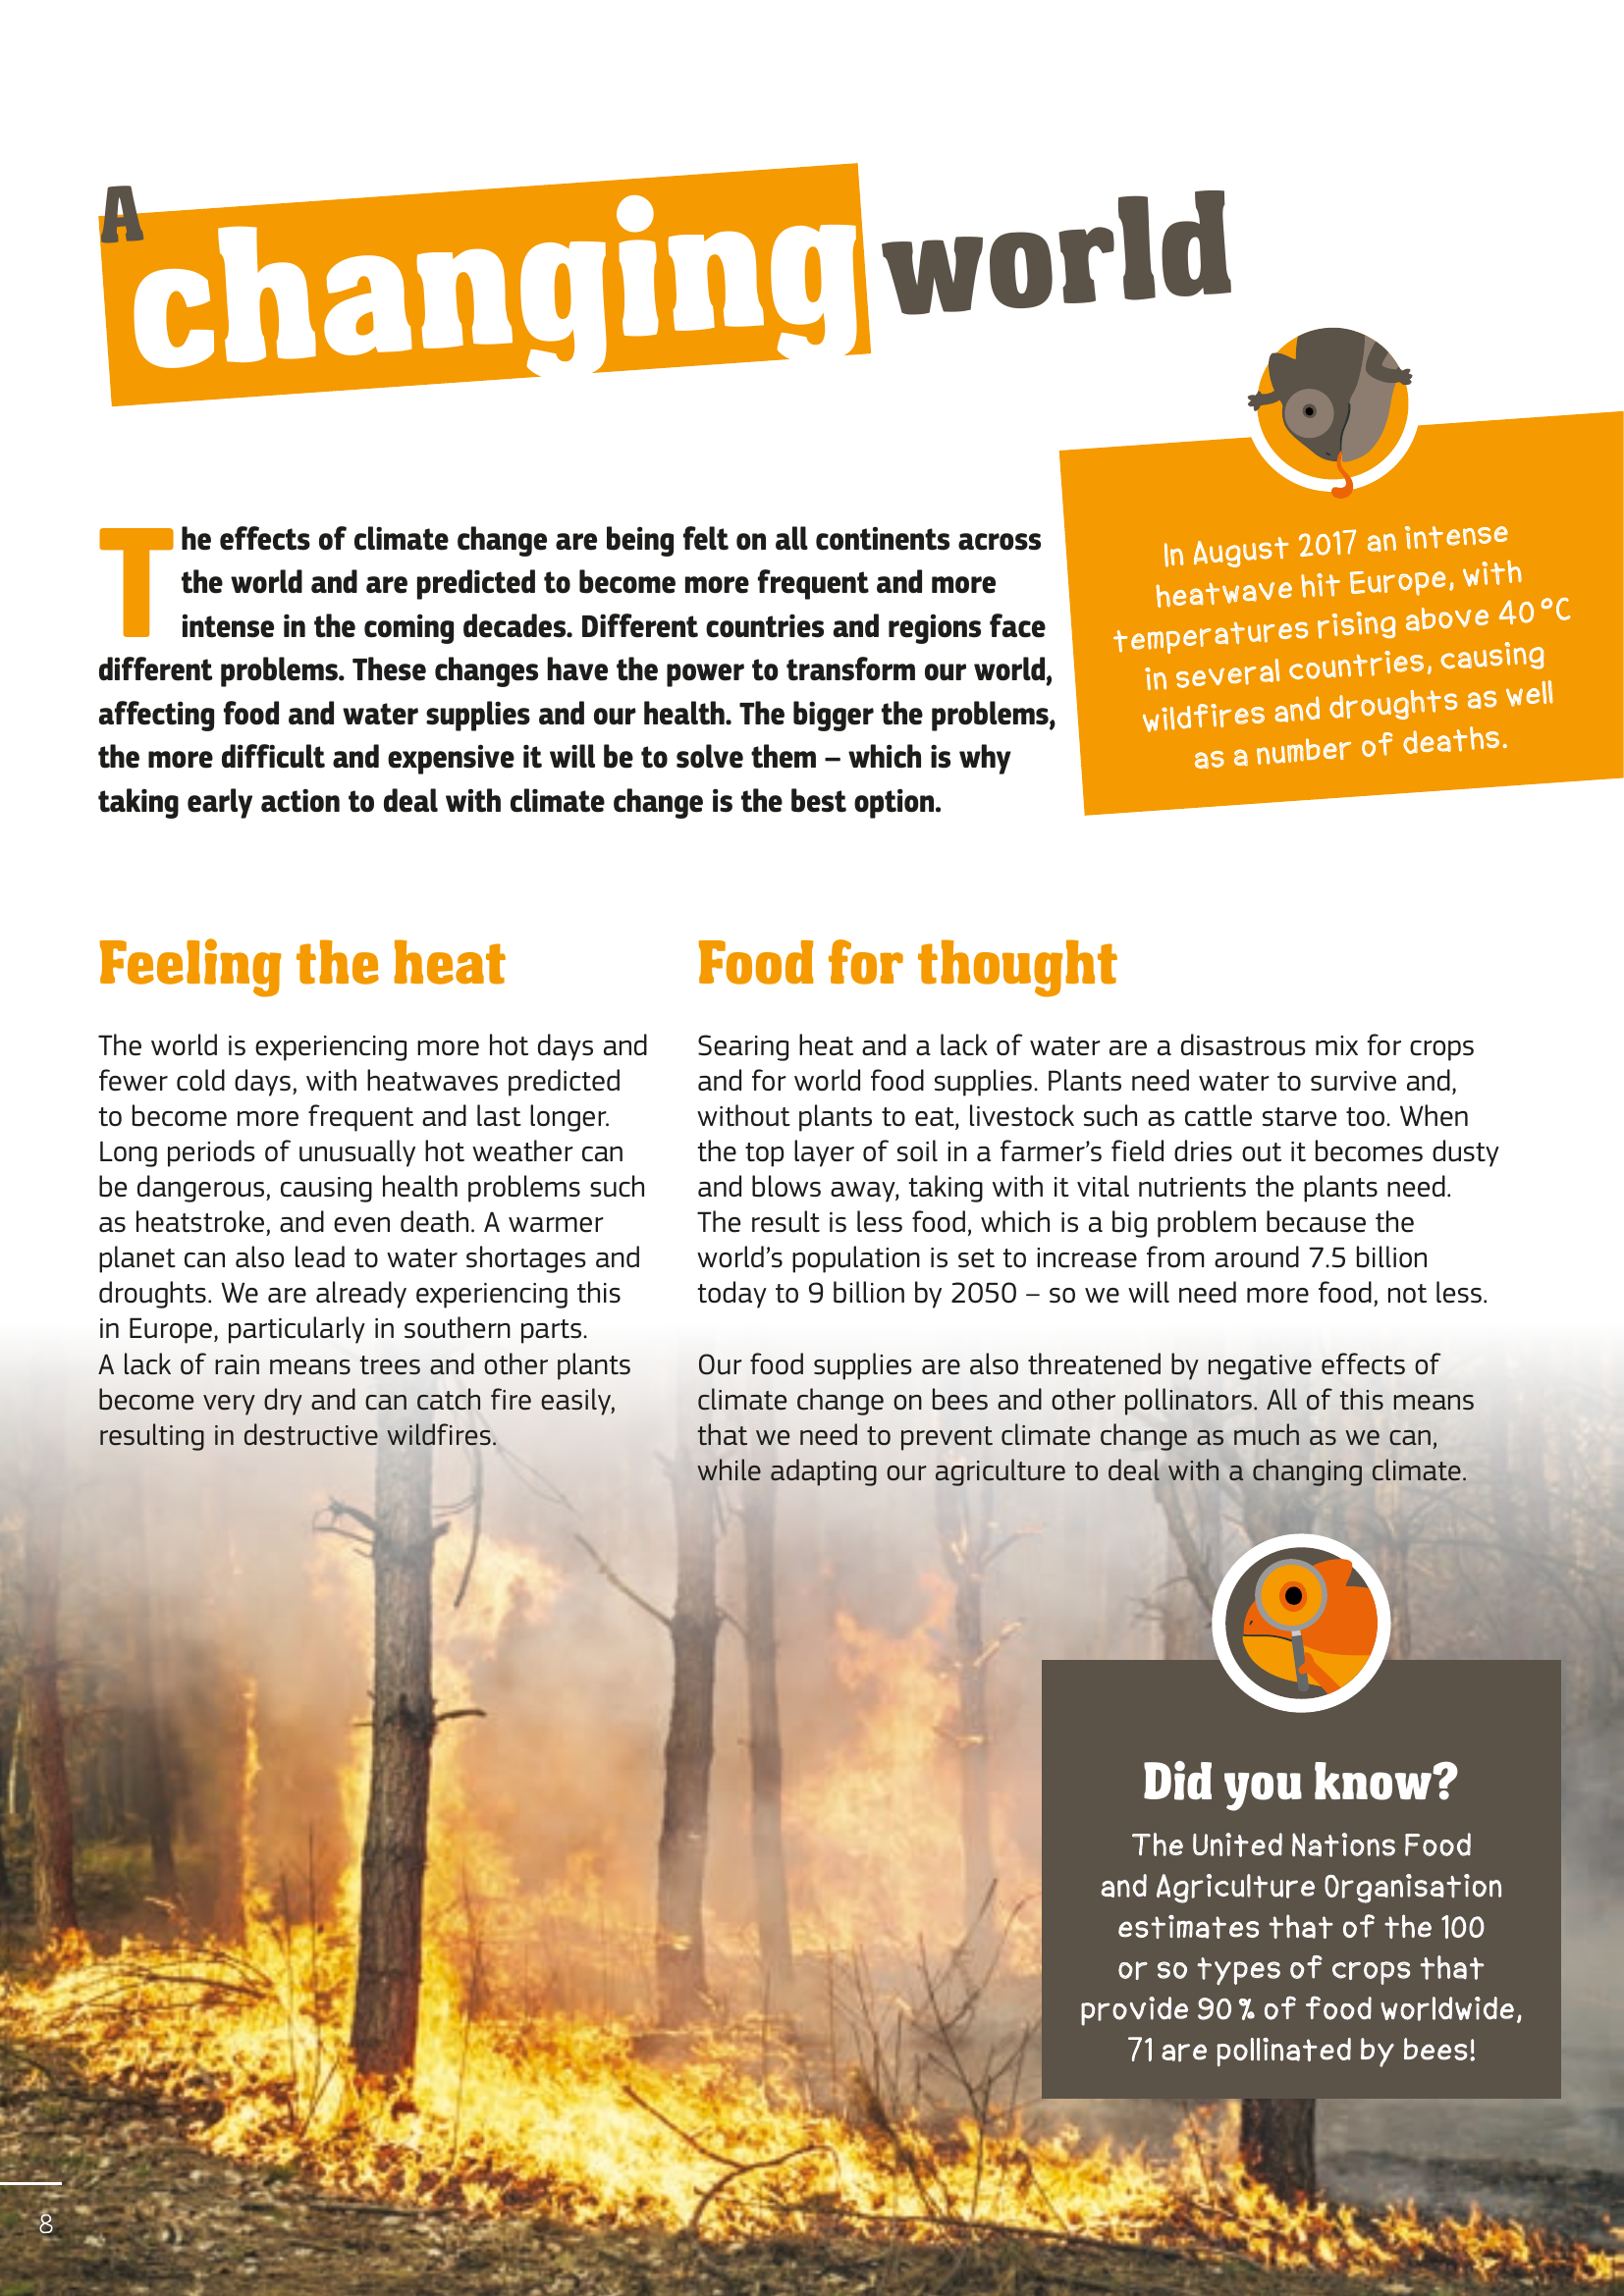

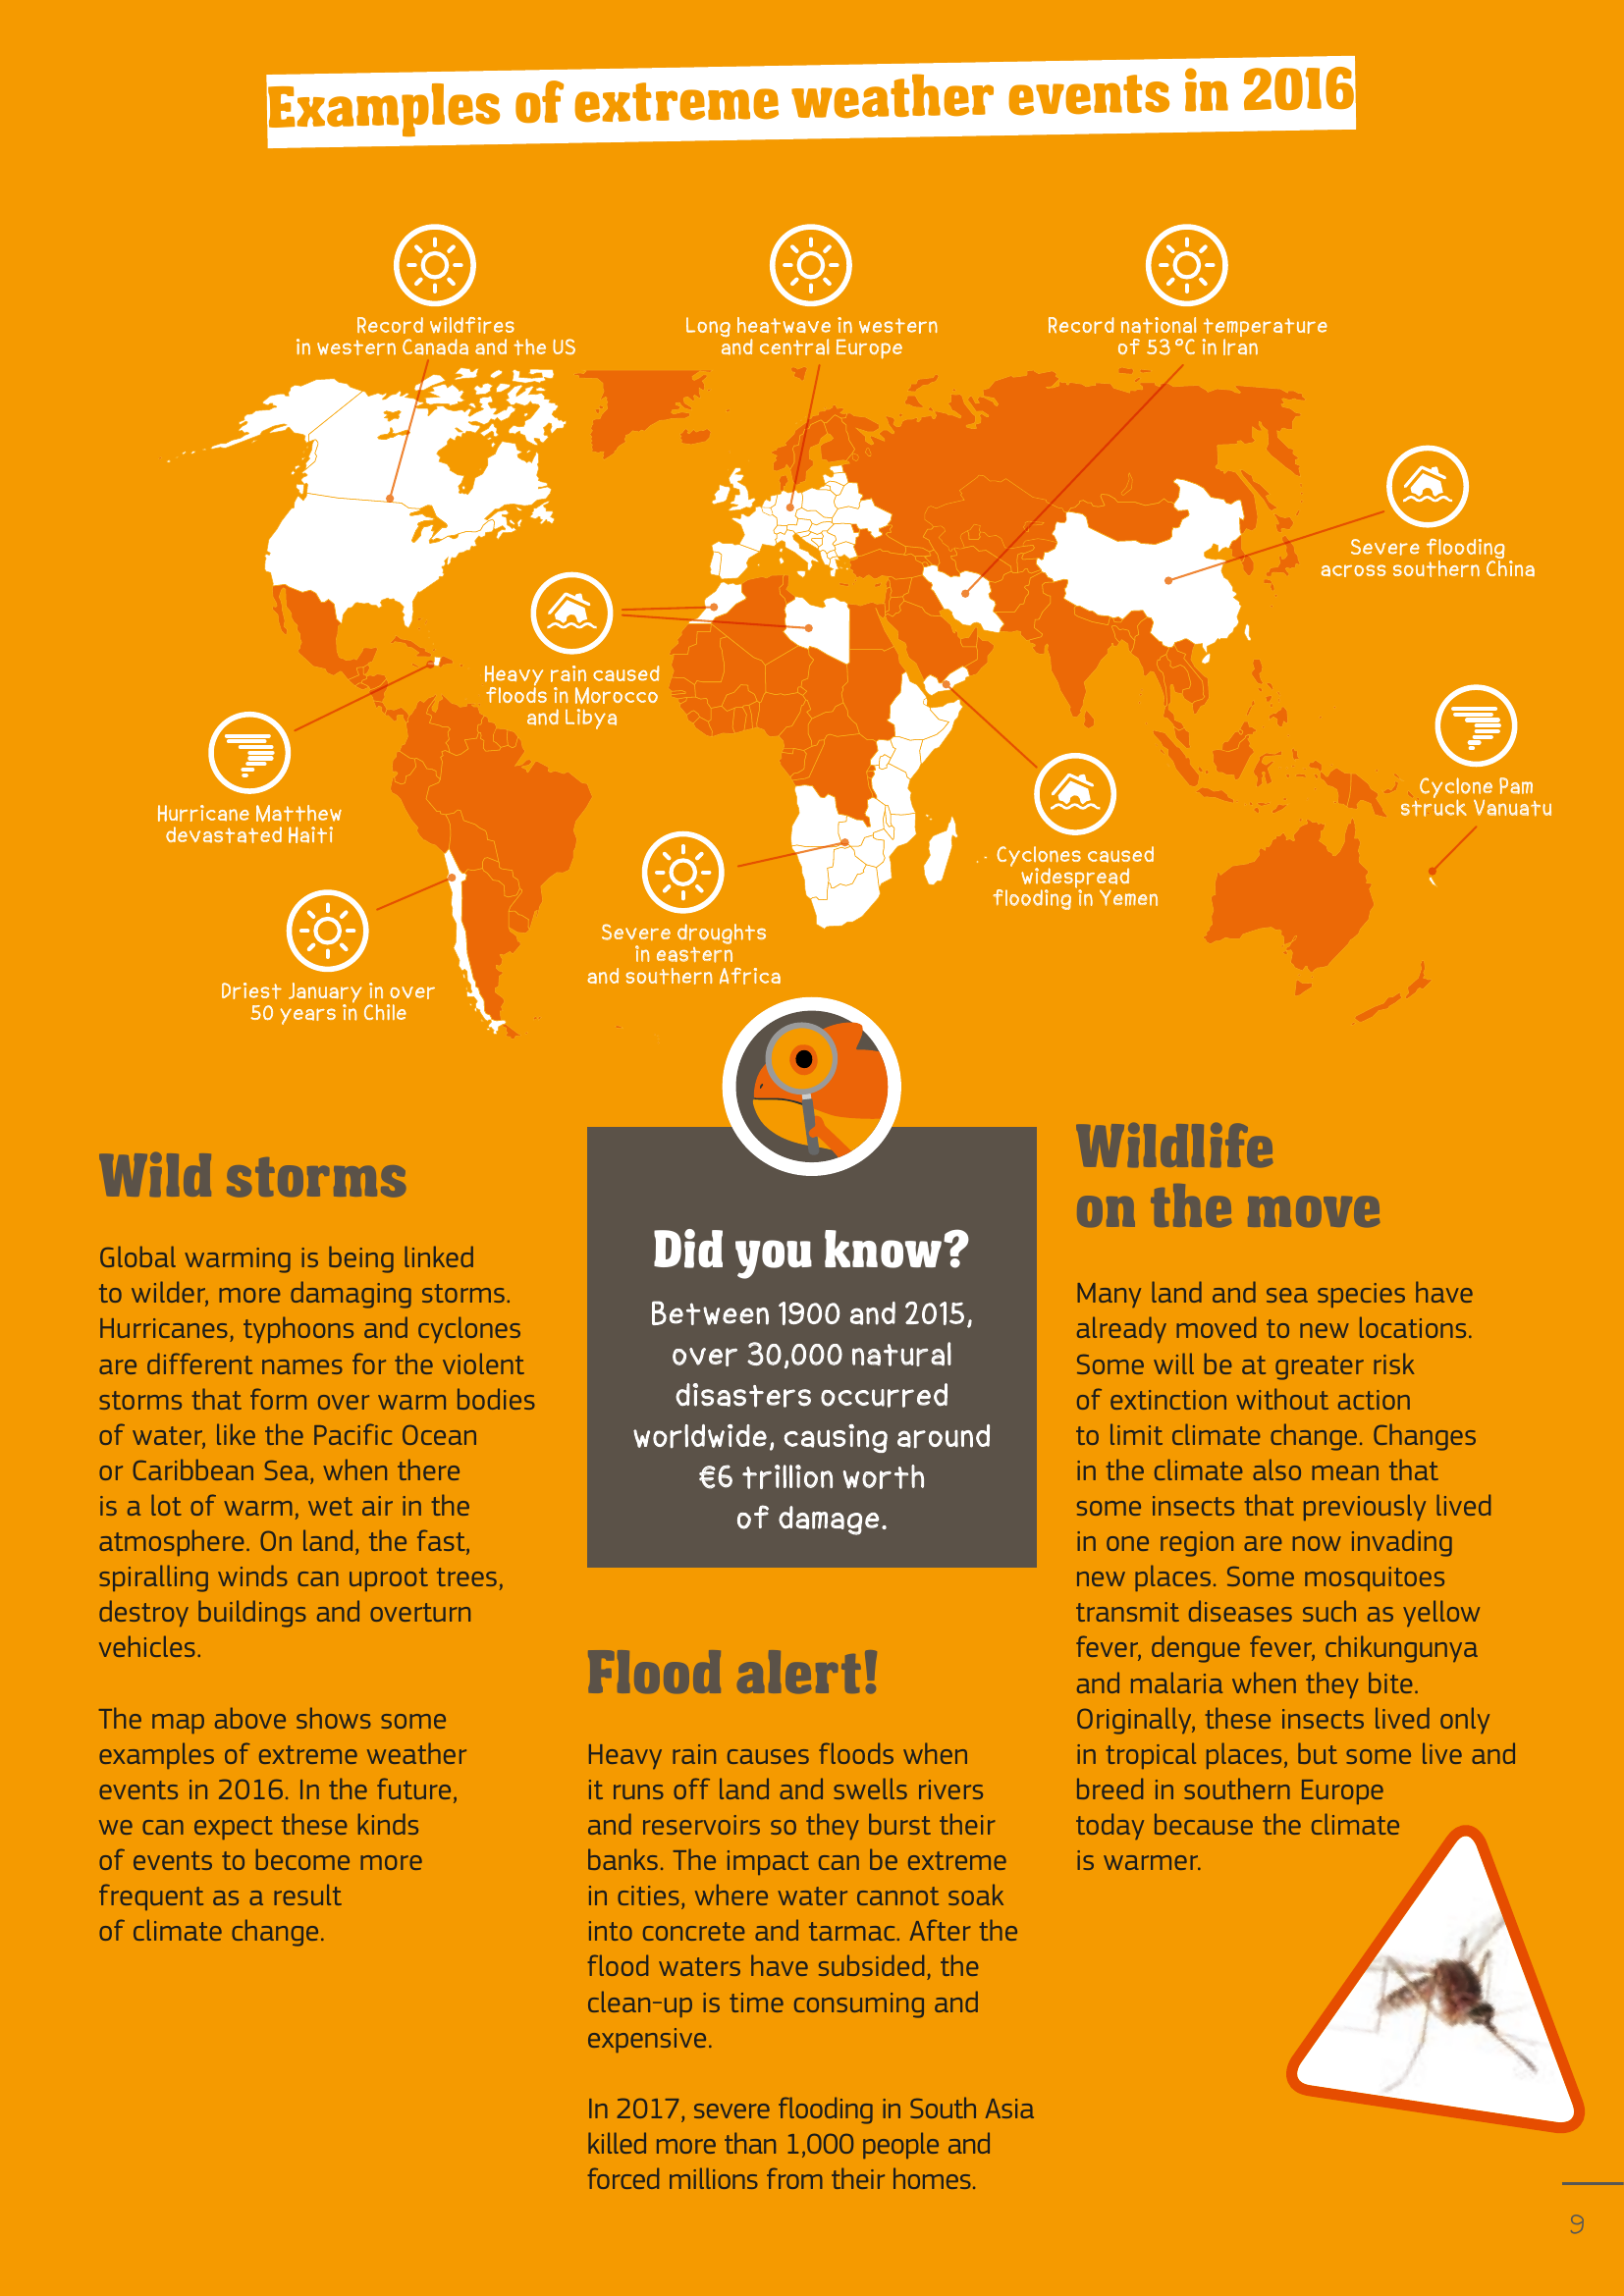

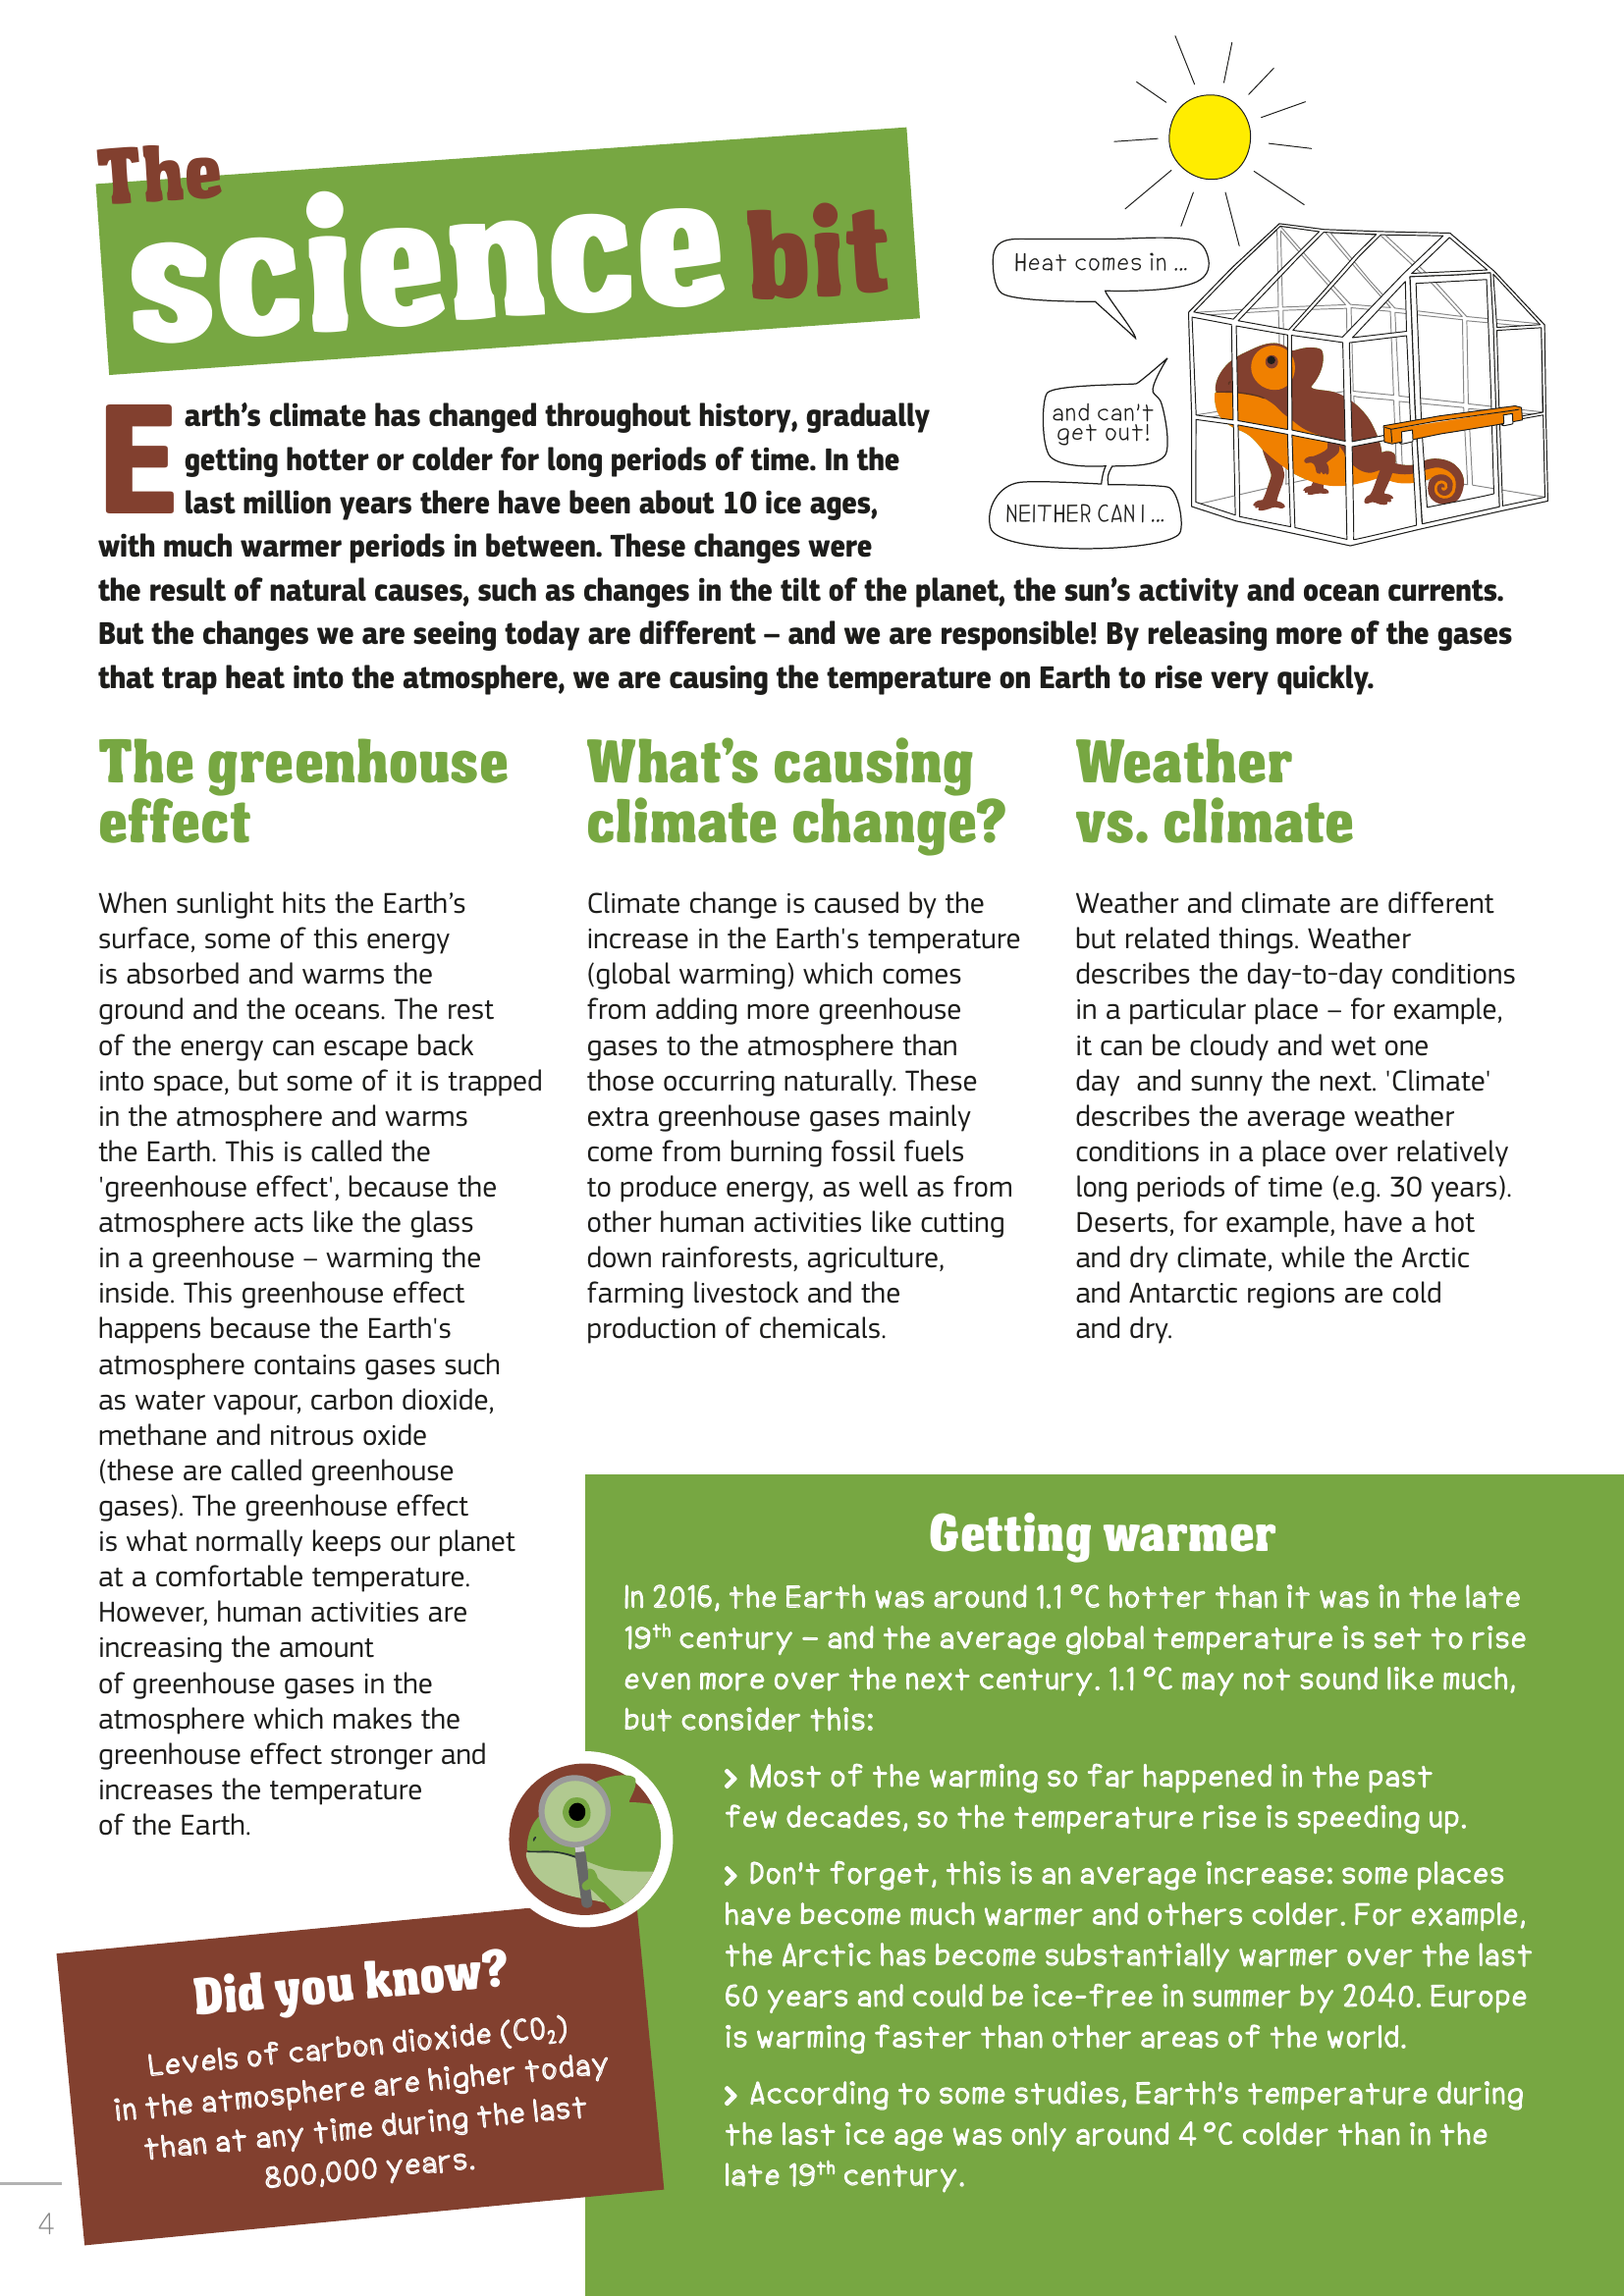

In [23]:
from IPython.display import Image as dImage
from io import BytesIO

for idx in top_k_indices:
    img = images[idx]
    with BytesIO() as output:
        img.save(output, format="PNG")
        display(dImage(data=output.getvalue()))
